In [1]:
# ============================
#       LIBRERÍAS
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# ============================
#       DATASET
# ============================
file_path = "/content/diet_recommendations_dataset (1).csv"
df = pd.read_csv(file_path)

# ============================
#       ENCODING
# ============================
categorical_columns = ["Gender", "Disease_Type", "Severity", "Physical_Activity_Level", "Dietary_Restrictions", "Allergies", "Preferred_Cuisine"]

encoders = {}
for col in categorical_columns:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

y_encoder = LabelEncoder()
df["Diet_Recommendation"] = y_encoder.fit_transform(df["Diet_Recommendation"])

# ============================
#       BALANCEO
# ============================
class_counts = df["Diet_Recommendation"].value_counts()
min_class_count = class_counts.min()

balanced_df = pd.concat([
    df[df["Diet_Recommendation"] == cls].sample(min_class_count, random_state=42)
    for cls in class_counts.index
])

X = balanced_df.drop(columns=["Diet_Recommendation", "Patient_ID"])
y = balanced_df["Diet_Recommendation"]

# ============================
#       TRAIN / TEST SPLIT 80/20
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [2]:
# ============================
#       K-FOLD CONFIG
# ============================
kfold = KFold(n_splits=5, shuffle=True, random_state=42)



[ Decision Tree - Baseline para Tesis ]
Mejores parámetros: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20}
Accuracy en Test: 1.0

[ Classification Report ]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        52

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



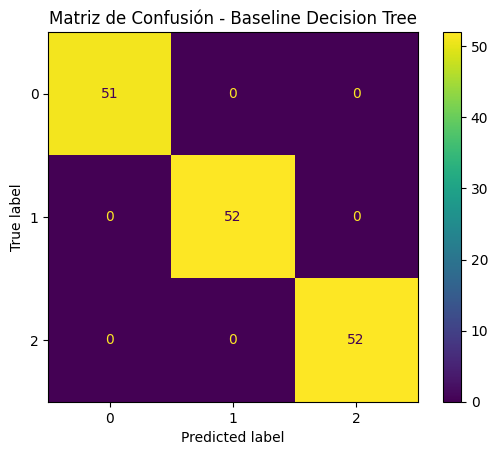

In [3]:
# ============================
#       Decision Tree
# ============================
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ========== Árbol restringido ==========
param_grid_dt = {
    'max_depth': [2, 3, 4],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [10, 15]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

# ========== Reportes ==========
print("\n[ Decision Tree - Baseline para Tesis ]")
print("Mejores parámetros:", grid_dt.best_params_)
print("Accuracy en Test:", grid_dt.score(X_test, y_test))

# Classification Report
y_pred_dt = grid_dt.predict(X_test)
print("\n[ Classification Report ]")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot()
plt.title("Matriz de Confusión - Baseline Decision Tree")
plt.show()


In [4]:
print("Tamaño total después de balanceo:", balanced_df.shape)
print("Distribución de clases:\n", balanced_df['Diet_Recommendation'].value_counts())


Tamaño total después de balanceo: (774, 20)
Distribución de clases:
 Diet_Recommendation
0    258
2    258
1    258
Name: count, dtype: int64



[ Random Forest ]
Mejores parámetros: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 9}
Accuracy en Test: 0.9871

[ Classification Report ]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       1.00      1.00      1.00        52
           2       0.98      0.98      0.98        52

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155


[ Matriz de Confusión ]
[[50  0  1]
 [ 0 52  0]
 [ 1  0 51]]


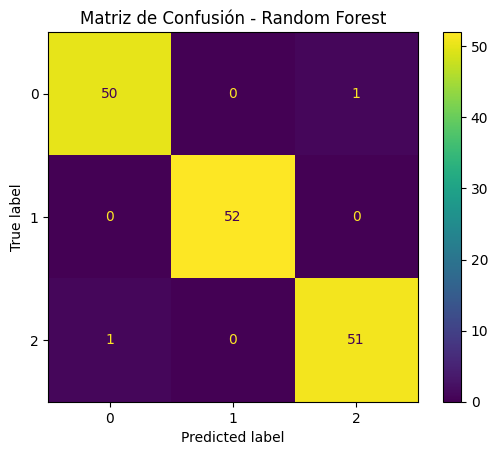

In [15]:
# ============================
#       Random Forest
# ============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

param_grid_rf = {
    'n_estimators': [5, 7, 9, 11],
    'max_depth': [3, 4, 5],
    'min_samples_split': [15, 20, 25],
    'min_samples_leaf': [10, 15, 20],
    'max_features': ['log2']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=kfold,
    scoring='accuracy'
)

# Entrenamiento
grid_rf.fit(X_train, y_train)

# ============================
#       Resultados completos
# ============================

print("\n[ Random Forest ]")
print("Mejores parámetros:", grid_rf.best_params_)

accuracy_rf = grid_rf.score(X_test, y_test)
print(f"Accuracy en Test: {accuracy_rf:.4f}")

# ============================
#       Classification Report
# ============================

y_pred_rf = grid_rf.predict(X_test)

print("\n[ Classification Report ]")
print(classification_report(y_test, y_pred_rf))

# ============================
#       Matriz de Confusión
# ============================

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\n[ Matriz de Confusión ]")
print(cm_rf)

ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Matriz de Confusión - Random Forest")
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3941 - loss: 1.4865 - val_accuracy: 0.3763 - val_loss: 1.3768
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3402 - loss: 1.5281 - val_accuracy: 0.3817 - val_loss: 1.3705
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3875 - loss: 1.4643 - val_accuracy: 0.4032 - val_loss: 1.3595
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3823 - loss: 1.4739 - val_accuracy: 0.4194 - val_loss: 1.3506
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4274 - loss: 1.3614 - val_accuracy: 0.4462 - val_loss: 1.3379
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5001 - loss: 1.3239 - val_accuracy: 0.4516 - val_loss: 1.3248
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4017 - loss: 1.4290 - val_accuracy: 0.4624 - val_loss: 1.3092
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5370 - loss: 1.3207 - val_accuracy: 0.4677 - val_loss: 1.

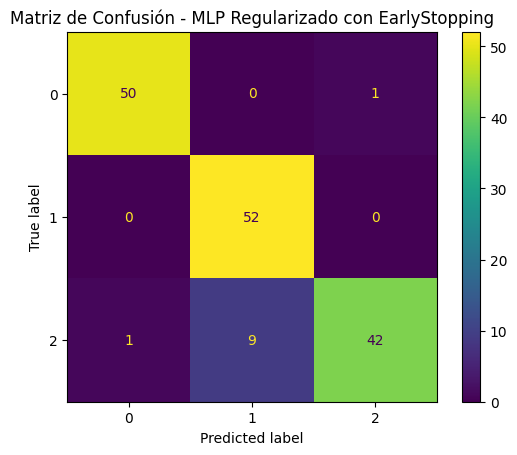

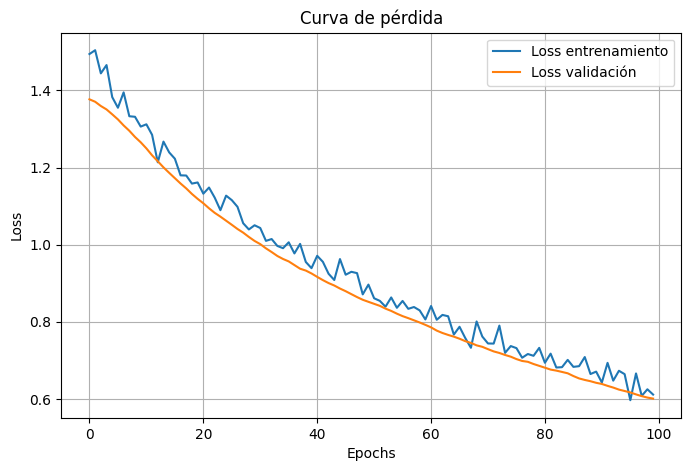

In [14]:
# ============================
#       LIBRERÍAS
# ============================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ============================
#       ESCALADO
# ============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
#       TRAIN / TEST SPLIT 80/20
# ============================
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ============================
#       MODELO MLP
# ============================
nn_model = keras.Sequential([
    layers.Dense(64, activation=None, kernel_regularizer=regularizers.l2(0.004), input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation=None, kernel_regularizer=regularizers.l2(0.004)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

# ============================
#       EARLY STOPPING
# ============================
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ============================
#       COMPILACIÓN
# ============================
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
nn_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ============================
#       ENTRENAMIENTO
# ============================
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.3,
    callbacks=[early_stopping],
    verbose=1
)

# ============================
#       EVALUACIÓN EN TEST
# ============================
nn_loss, nn_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network Accuracy en TEST: {nn_accuracy:.4f}")

# ============================
#       MÉTRICAS COMPLETAS
# ============================

y_pred_test = np.argmax(nn_model.predict(X_test_scaled), axis=1)

print("\n[ Classification Report ]")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
print("\n[ Matriz de Confusión ]")
print(cm)

ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusión - MLP Regularizado con EarlyStopping")
plt.show()

# ============================
#       CURVA DE APRENDIZAJE
# ============================

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.legend()
plt.title("Curva de pérdida")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



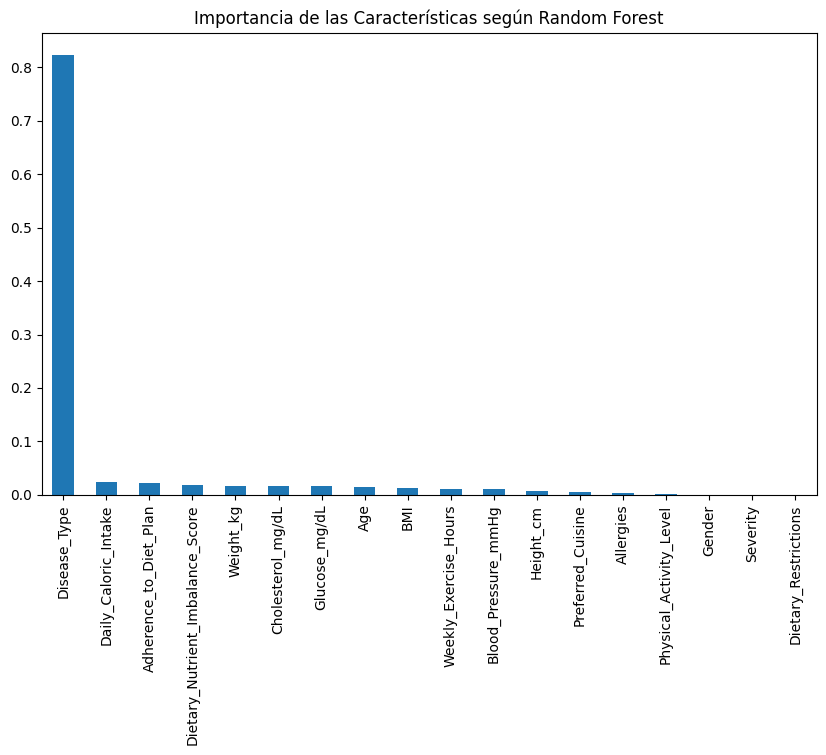

In [11]:
# Feature Importance
rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title('Importancia de las Características según Random Forest')
plt.show()


In [ ]:
# ============================
#       DATASET
# ============================
file_path = "/content/diet_recommendations_dataset (1).csv"
df = pd.read_csv(file_path)

# ============================
#       ENCODING
# ============================
categorical_columns = ["Gender", "Disease_Type", "Severity", "Physical_Activity_Level", "Dietary_Restrictions", "Allergies", "Preferred_Cuisine"]

encoders = {}
for col in categorical_columns:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

y_encoder = LabelEncoder()
df["Diet_Recommendation"] = y_encoder.fit_transform(df["Diet_Recommendation"])

X = df.drop(columns=["Diet_Recommendation", "Patient_ID"])
y = df["Diet_Recommendation"]

# ============================
#       BALANCEO
# ============================

class_counts = y.value_counts()
min_class_count = class_counts.min()

balanced_df = pd.concat([
    df[df["Diet_Recommendation"] == cls].sample(min_class_count, random_state=42)
    for cls in class_counts.index
])



[ Feature Selection ]
Características seleccionadas:
['Disease_Type', 'Preferred_Cuisine', 'Glucose_mg/dL', 'BMI', 'Cholesterol_mg/dL', 'Adherence_to_Diet_Plan', 'Height_cm']

[ Random Forest - Feature Selection ]
Mejores parámetros: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 6}
Accuracy en Test: 0.9677

[ Classification Report ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        51
           1       1.00      0.90      0.95        52
           2       0.95      1.00      0.97        52

    accuracy                           0.97       155
   macro avg       0.97      0.97      0.97       155
weighted avg       0.97      0.97      0.97       155


[ Matriz de Confusión ]
[[51  0  0]
 [ 2 47  3]
 [ 0  0 52]]


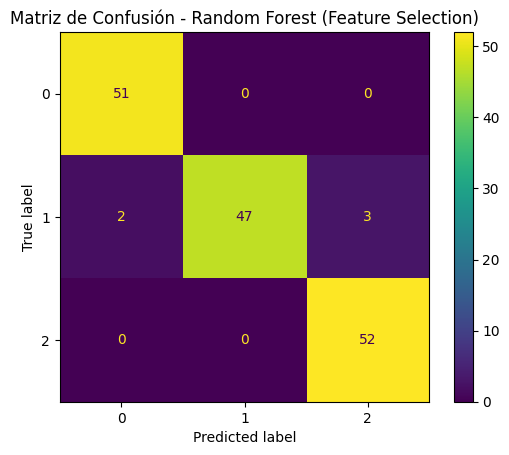

In [16]:
# ============================
#       FEATURE SELECTION
# ============================

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

# Seleccionamos solo variables categóricas para ordinal encoding (mejor para mutual_info)
X_encoded = X.copy()
ordinal_encoder = OrdinalEncoder()
X_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

# Calculamos la importancia de cada feature
mi_scores = mutual_info_classif(X_encoded, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

# Forzar que Disease_Type y Preferred_Cuisine siempre estén
forced_features = ['Disease_Type', 'Preferred_Cuisine']

# Seleccionamos las 5 mejores adicionales SIN repetir
top_k = 5
top_features = [f for f in mi_series.index if f not in forced_features][:top_k]

# Conjunto final de características seleccionadas
selected_features = forced_features + top_features

print("\n[ Feature Selection ]")
print("Características seleccionadas:")
print(selected_features)

# ============================
#       TRAIN - TEST SPLIT
# ============================

X_selected = X[selected_features]

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# ============================
#   Random Forest - Feature Selection
# ============================

grid_rf_fs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf_fs,
    cv=kfold,
    scoring='accuracy'
)

grid_rf_fs.fit(X_train_fs, y_train_fs)

# ----------------------------
# Resultados completos
# ----------------------------

print("\n[ Random Forest - Feature Selection ]")
print("Mejores parámetros:", grid_rf_fs.best_params_)

accuracy_rf_fs = grid_rf_fs.score(X_test_fs, y_test_fs)
print(f"Accuracy en Test: {accuracy_rf_fs:.4f}")

# ----------------------------
# Reporte de Clasificación
# ----------------------------

y_pred_rf_fs = grid_rf_fs.predict(X_test_fs)

print("\n[ Classification Report ]")
print(classification_report(y_test_fs, y_pred_rf_fs))

# ----------------------------
# Matriz de Confusión
# ----------------------------

cm_rf_fs = confusion_matrix(y_test_fs, y_pred_rf_fs)
print("\n[ Matriz de Confusión ]")
print(cm_rf_fs)

ConfusionMatrixDisplay(cm_rf_fs).plot()
plt.title("Matriz de Confusión - Random Forest (Feature Selection)")
plt.show()

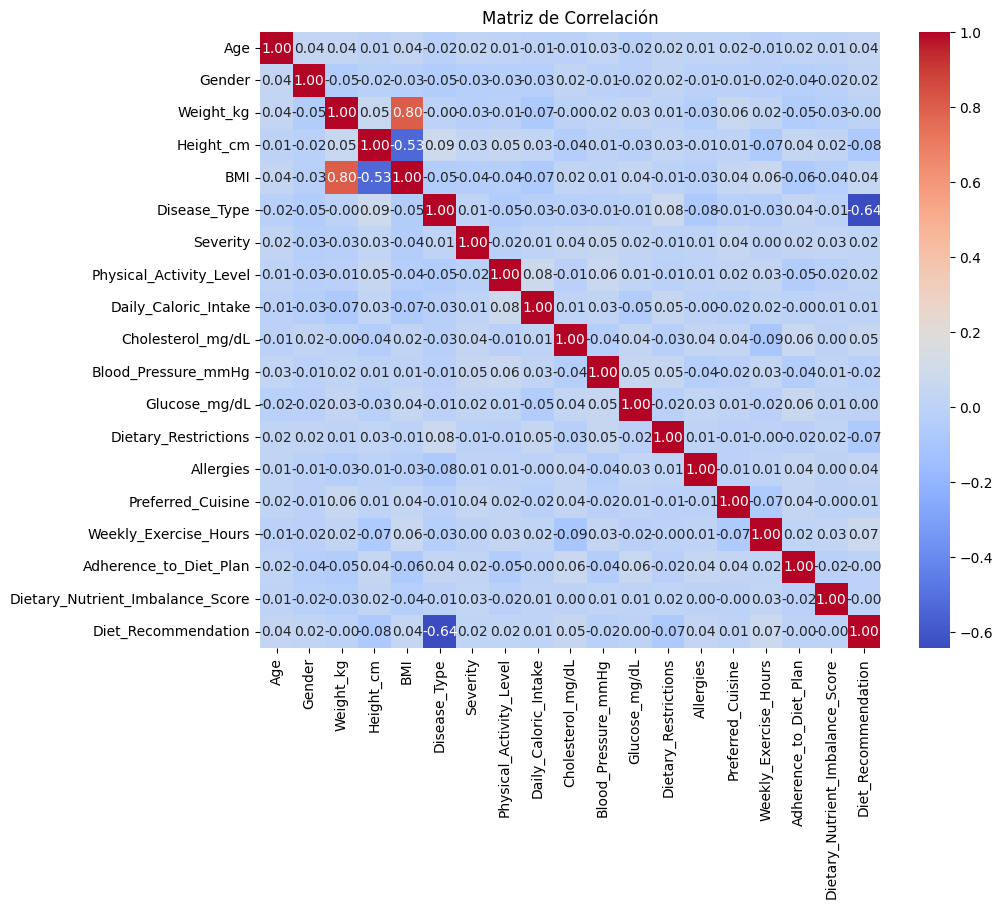


Correlación de las variables con la variable objetivo:
Weekly_Exercise_Hours               0.074492
Cholesterol_mg/dL                   0.045351
BMI                                 0.041537
Age                                 0.037256
Allergies                           0.035032
Gender                              0.022333
Physical_Activity_Level             0.017870
Severity                            0.016317
Preferred_Cuisine                   0.012612
Daily_Caloric_Intake                0.010624
Glucose_mg/dL                       0.002523
Weight_kg                          -0.003891
Dietary_Nutrient_Imbalance_Score   -0.004323
Adherence_to_Diet_Plan             -0.004994
Blood_Pressure_mmHg                -0.022256
Dietary_Restrictions               -0.070437
Height_cm                          -0.082120
Disease_Type                       -0.640856
Name: Diet_Recommendation, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos
df = pd.read_csv("/content/diet_recommendations_dataset (1).csv")

# Encoding de las variables categóricas
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["Gender", "Disease_Type", "Severity", "Physical_Activity_Level",
                       "Dietary_Restrictions", "Allergies", "Preferred_Cuisine"]

for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

df["Diet_Recommendation"] = LabelEncoder().fit_transform(df["Diet_Recommendation"])

# Exclude 'Patient_ID' from the correlation calculation
correlation_matrix = df.drop(columns=['Patient_ID']).corr() #FIXED: Drop 'Patient_ID' before calculating correlation

# Mostrar matriz completa
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# Mostrar solo correlación de las variables con la variable objetivo
target_corr = correlation_matrix["Diet_Recommendation"].drop("Diet_Recommendation").sort_values(ascending=False)
print("\nCorrelación de las variables con la variable objetivo:")
print(target_corr)


In [ ]:
# ============================
# Exportar modelo Feature Selection (RF)
# ============================

import pickle

# Empaquetamos:
# 1. El modelo entrenado
# 2. El scaler usado
# 3. Las características seleccionadas

modelo_fs = {
    "model": grid_rf_fs.best_estimator_,   # Modelo RF Feature Selection entrenado
    "scaler": scaler_fs,                   # Scaler ajustado al train de Feature Selection
    "features": selected_features          # Lista de features seleccionadas
}

# Guardar en formato pickle
with open("random_forest_fs_model.pkl", "wb") as f:
    pickle.dump(modelo_fs, f)

print("✅ Modelo RF (Feature Selection) exportado correctamente a random_forest_fs_model.pkl")


✅ Modelo RF (Feature Selection) exportado correctamente a random_forest_fs_model.pkl


In [ ]:
import joblib
model = joblib.load("/content/random_forest_fs_model.pkl")
print(type(model))


<class 'dict'>


In [ ]:
# ✅ Guardar correctamente el modelo
import joblib
joblib.dump(grid_rf_fs.best_estimator_, "rf_feature_selection.pkl")


['rf_feature_selection.pkl']